In [ ]:
!pip install -Uqq duckduckgo_search

# Introduccion
Este es un simple programa que trata de reconocer si es un perro o no.
1.   Usamos DuckDuckGo para buscar imagenes de perros.
2.   Usamos DuckDuckGo para buscar imagenes de caballos.

1.   Por ultimo le hacemos fine-tuning a un modelo pre-entrenado para reconocer estos dos grupos.







# Empezamos descargando las imagenes de perros y no perros

In [11]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200):
   return L(ddg_images(term, max_results=max_images)).itemgot('image')
     

Empezemos buscando una imagen de un perro a ver que resultado nos tira

In [24]:
urls = search_images('dog photo', max_images=1)
urls[0]

'https://static.businessinsider.com/image/5484d9d1eab8ea3017b17e29/image.jpg'

Y ahora descargando la URL y visualizarla

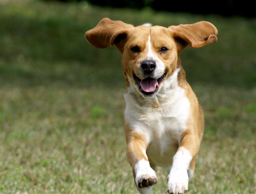

In [25]:
from fastdownload import download_url
dest = 'dog.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Ahora hagamos lo mismo pero con un caballo

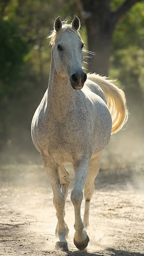

In [26]:
download_url(search_images('horse photo', max_images=1)[0], 'horse.jpg', show_progress=False)
Image.open('horse.jpg').to_thumb(256,256)

Ahora agarremos 200 imagenes de perros y caballos y guardemoslas en carpetas diferentes

In [35]:
searches = 'horse','dog'
path = Path('dog_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} border collie photo'))
    sleep(10)  # Pausa entre busquedas para evitar la sobre-carga del servidor
    download_images(dest, urls=search_images(f'{o} unicorn photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} horse field'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


# Ahora a entrenar el modelo

Algunas fotos pueden que se descarguen mal y eso perjudique a nuestro modelo. Eliminemoslas

In [36]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

18

Creamos un datablock que es un objeto que contiene set de entrenamiento y un set de validacion

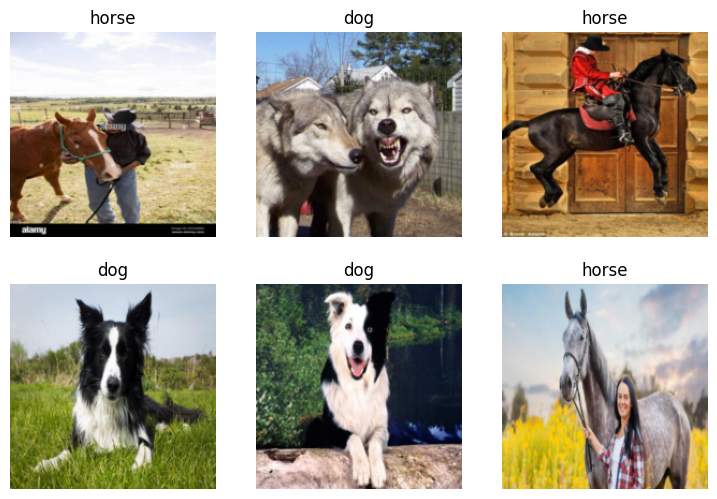

In [37]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Usamos resnet18 para entrenar el modelo. Y aplicamos el fine-tuning

In [38]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.095356,0.717508,0.245000,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.690088,0.633685,0.245000,00:04
1,0.466545,0.701651,0.230000,00:06
2,0.349501,0.687030,0.215000,00:05


In [39]:
is_dog,_,probs = learn.predict(PILImage.create('dog.jpg'))
print(f"This is a: {is_dog}.")
print(f"Probability it's a dog: {probs[0]:.4f}")

This is a: dog.
Probability it's a dog: 0.9942
